# Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import tqdm.auto as tqdm
from pprint import pprint
import collections
import random
import feather
from sklearn import metrics

# Use restricted_wcc dataset (only courses from WCC, no summer, keep only row from last five years or from a student with a course in the last five years) from wrangling_restricted_wcc_dataset.ipynb

In [2]:
WCC_PD_PATH = "../data/wcc_pd.pkl"

with open(WCC_PD_PATH, "rb") as file:
    raw_data = pickle.load(file)
    
raw_data

,acad_career,strm,stdnt_enrl_status,unt_taken,unt_billing,crse_grade_input,earn_credit,emplid,subject,catalog_nbr,crse_acad_org,sex,gpa,grade_points,total_units,cum_grade_points,cum_units,overall_gpa,prior_term_gpa,course_name
0,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,MATH,51,MATH,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,MATH51
1,UG,1182.0,E,0.0,0.0,None,N,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,31X,CHEMISTRY,M,NaN,72.0,18.0,72.0,18.0,4.000000,NaN,CHEM31X
2,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,31X,CHEMISTRY,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,CHEM31X
3,UG,1182.0,E,0.0,0.0,None,N,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,MATH,51,MATH,M,NaN,72.0,18.0,72.0,18.0,4.000000,NaN,MATH51
4,UG,1184.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CS,106X,COMPUTSCI,M,4.0,65.1,17.0,137.1,35.0,3.917143,4.0,CS106X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784350,UG,1202.0,E,5.0,5.0,B,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31A,CHEMISTRY,F,3.0,39.0,11.0,39.0,11.0,3.545455,NaN,CHEM31A
784351,UG,1202.0,E,0.0,0.0,None,N,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31A,CHEMISTRY,F,NaN,39.0,11.0,39.0,11.0,3.545455,NaN,CHEM31A
784352,UG,1204.0,E,5.0,5.0,None,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,PSYCH,1,PSYCHOLOGY,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PSYCH1
784353,UG,1204.0,E,5.0,5.0,None,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31B,CHEMISTRY,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEM31B


In [3]:
all_courses = set(raw_data["course_name"])
pprint(all_courses)
print(len(all_courses))

{'AA100',
 'AA200',
 'AA210A',
 'AA212',
 'AA214A',
 'AA214B',
 'AA228',
 'AA229',
 'AA240A',
 'AA240B',
 'AA241A',
 'AA241B',
 'AA241X',
 'AA242A',
 'AA256',
 'AA270',
 'AA271A',
 'AA272C',
 'AA279A',
 'AA279B',
 'AA280',
 'APPPHYS220',
 'APPPHYS272',
 'APPPHYS273',
 'BIO101',
 'BIO104',
 'BIO107',
 'BIO115',
 'BIO144',
 'BIO153',
 'BIO156',
 'BIO158',
 'BIO163',
 'BIO173',
 'BIO188',
 'BIO189',
 'BIO234',
 'BIO239',
 'BIO256',
 'BIO258',
 'BIO41',
 'BIO42',
 'BIO43',
 'BIO44X',
 'BIO44Y',
 'BIOE101',
 'BIOE103',
 'BIOE103B',
 'BIOE123',
 'BIOE141A',
 'BIOE141B',
 'BIOE201C',
 'BIOE210',
 'BIOE211',
 'BIOE212',
 'BIOE244',
 'BIOE280',
 'BIOE300A',
 'BIOE301C',
 'BIOE311',
 'BIOE313',
 'BIOE355',
 'BIOE41',
 'BIOE42',
 'BIOE44',
 'BIOE454',
 'BIOHOPK163H',
 'BIOHOPK167H',
 'BIOHOPK263H',
 'BIOMEDIN156',
 'BIOMEDIN210',
 'BIOMEDIN212',
 'BIOMEDIN214',
 'BIOMEDIN215',
 'BIOMEDIN217',
 'BIOMEDIN218',
 'BIOMEDIN224',
 'BIOMEDIN225',
 'BIOMEDIN256',
 'BIOMEDIN260',
 'BIOMEDIN371',
 'BIOPHYS

 'STATS167',
 'STATS191',
 'STATS195',
 'STATS200',
 'STATS202',
 'STATS203',
 'STATS206',
 'STATS207',
 'STATS215',
 'STATS217',
 'STATS219',
 'STATS221',
 'STATS231',
 'STATS240',
 'STATS244',
 'STATS250',
 'STATS263',
 'STATS267',
 'STATS270',
 'STATS271',
 'STATS290',
 'STATS300A',
 'STATS305',
 'STATS306A',
 'STATS310A',
 'STATS310B',
 'STATS310C',
 'STATS311',
 'STATS315A',
 'STATS316',
 'STATS344',
 'STATS350',
 'STATS360',
 'STATS363',
 'STATS370',
 'STATS371',
 'STATS374',
 'STATS376A',
 'STATS50',
 'STATS60',
 'SYMSYS100'}
1012


In [4]:
# descriptive statistics
print(len(raw_data), "unique course records")
print(len(raw_data["emplid"].unique()), "unique students")
print(len(raw_data["course_name"].unique()), "unique courses")

317636 unique course records
13709 unique students
1012 unique courses


In [5]:
OFFICIAL_PREREQ_PATH = "../data/official_reqs.pkl"

with open(OFFICIAL_PREREQ_PATH, "rb") as file:
    official_prereqs = pickle.load(file)
    
pprint(official_prereqs["CS110"])
pprint(official_prereqs["CS221"])
# pprint(official_prereqs)

['CS107']
['CS103', 'CS106B', 'CS106X', 'CS107', 'CS109']


In [21]:
def getTargetGPAColumn(gpaString):
    gpaString = str(gpaString)
    gpaString = gpaString.lower()
    if gpaString == "nan":
        return "gpa_NaN"
    gpaValue = float(gpaString)
    if gpaValue > 3.7:
        return "gpa_A"
    elif gpaValue > 2.7:
        return "gpa_B"
    elif gpaValue > 1.7:
        return "gpa_C"
    elif gpaValue > 0.7:
        return "gpa_D"
    else:
        return "gpa_NP"

In [22]:
# Builds the feature matrix X and output vector y for a given course, using all other courses in the dataset
# as possible predictors. Only adds a column for another course if at least one student has taken that other
# course before the given course.
# Set gender = True to also add a prediction vector for female (0/1).
# Returns a dataframe with y appended to the right of X, split them off later in get_and_split_data().
############################################################################################################
# 2020-02-23 Initial model settings: 
# Predict success in a course (B+ or better) based on having passed other courses previously (D- or better)
# Incomplete data for strm 1204 (2019-2020 Winter)
# Only consider courses taken at or after strm 1162 (2015-2016 Autumn)
# Y1GRADES = ["A+", "A", "A-", "B+"]
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"]
# UNFINISHED_QUARTERS = [1204]
# CUTOFF_QUARTER = 1162

# Y1GRADES = ["A+", "A", "A-", "B+"] # we encode these grades as y = 1, otherwise y = 0
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"] # for previous courses, encode these grades as X_i = 1
UNFINISHED_QUARTERS = [1204] # unfinished quarter(s) if pulled during a quarter
CUTOFF_QUARTER = 1162

# added x1param and y1param as optional parameters, use these or custom lists
LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
SUCCESS_GRADES = ["A+", "A", "A-", "B+"]

def getStudentFeatures(target_course, gender = False, gpa = False, prereqSuccess = False,
                       x1param = PASS_GRADES, y1param = SUCCESS_GRADES, prereqs = False):
    if prereqSuccess:
        x1param = SUCCESS_GRADES
    course_entries = raw_data.loc[(raw_data['course_name'] == target_course) & # all course entries that are about the certain course we want
                                  (raw_data['crse_grade_input'].isin(LETTER_GRADES)) & # Grade needs to be a letter
                                  (raw_data['stdnt_enrl_status'] != 'D') & # not dropped
                                  (raw_data['strm'] >= CUTOFF_QUARTER) & # target (outcome) course during or after the cutoff
                                  (~raw_data['strm'].isin(UNFINISHED_QUARTERS))] # we don't have outcomes for these
    students = course_entries.emplid # Students from the course entries
    students_prev_classes = raw_data.loc[raw_data['emplid'].isin(students)] # Other classes taken by these students
    possible_prev_classes = students_prev_classes['course_name'].unique().tolist() # List of courses taken by these students
    possible_prev_classes.append("strm") # For now add term to the data of when the course was taken
    if gender:
        possible_prev_classes.append("female") # Add gender
    if gpa: # Add GPA
        possible_prev_classes.append("gpa_A")
        possible_prev_classes.append("gpa_B")
        possible_prev_classes.append("gpa_C")
        possible_prev_classes.append("gpa_D")
        possible_prev_classes.append("gpa_NP")
        possible_prev_classes.append("gpa_NaN")
    possible_prev_classes.append("emplid") # Add emplid
    possible_prev_classes.append("y") # Add the target to the data. Will split it later
    a = np.zeros(shape = (len(course_entries), len(possible_prev_classes))) # all 0 initialized features matrix
    full_matrix = pd.DataFrame(a, columns = possible_prev_classes) # same as above, but in pandas to allow indexing by course name
    for counter, idx in enumerate(course_entries.index): # loop over all class entries
        grade = course_entries.loc[[idx]]['crse_grade_input']
        gradeStr = grade.tolist()[0]
        if (gradeStr in y1param):
            full_matrix.iloc[counter, full_matrix.columns.get_loc("y")] = 1
        # fill predictor matrix X
        std_id = course_entries.loc[[idx]]['emplid'] # Get the student id
        quarter = course_entries.loc[[idx]]['strm'] # Get the term
        student_courses = students_prev_classes.loc[students_prev_classes['emplid'] == std_id.tolist()[0]] # Get all courses the student took
        student_courses = student_courses.loc[student_courses['strm'] < quarter.tolist()[0]] # Filter the courses to be only before the course of interest
        if gender:
            female = course_entries.loc[[idx]]['sex'] # Get the student gender
            if (female.tolist()[0] == 'M'):
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 0
            else:
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 1
        if gpa:
            prior_GPA = course_entries.loc[[idx]]['prior_term_gpa'] # Get the student's GPA for the previous term
            full_matrix.iloc[counter, full_matrix.columns.get_loc(getTargetGPAColumn(prior_GPA.tolist()[0]))] = 1
        full_matrix.iloc[counter, full_matrix.columns.get_loc("strm")] = quarter.tolist()[0]
        full_matrix.iloc[counter, full_matrix.columns.get_loc("emplid")] = std_id.tolist()[0]
        for j in student_courses.index:# Loop over the student's courses
            course_name = student_courses.loc[[j]]['subject']+student_courses.loc[[j]]['catalog_nbr'] # Get the course name
            grade = student_courses.loc[[j]]['crse_grade_input']
            gradeStr = grade.tolist()[0]
            if (gradeStr in x1param):
                full_matrix.iloc[counter, full_matrix.columns.get_loc(course_name.tolist()[0])] = 1 # Set the course name in X to the new value (or if it was already passed keep the value)
    if not prereqs:
        return full_matrix
    
    # compute prereq_matrix with official prereq pickle
    prereq_columns = official_prereqs[target_course] + ['strm', 'emplid', 'y']
    if gender:
        prereq_columns.extend(['female'])
    if gpa:
        prereq_columns.extend(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'])
    prereq_matrix = full_matrix[prereq_columns]
    return full_matrix, prereq_matrix

In [ ]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = PASS_GRADES, y1param = PASS_GRADES)
features_cs110_testparams

In [ ]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = SUCCESS_GRADES, y1param = SUCCESS_GRADES)
features_cs110_testparams

In [14]:
full_cs110, prereqs_cs110 = getStudentFeatures("CS110", prereqs = True)

In [ ]:
full_cs110

In [ ]:
prereqs_cs110

# Logistic regression models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [24]:
UNSEEN_QUARTERS = [1204]
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

def get_and_split_data_double_matrix(target_course, test_quarters = TEST_QUARTERS,
                                     gender = False, gpa = False, x1param = PASS_GRADES,
                                     y1param = SUCCESS_GRADES, random_seed = 42, dev = True):
    dataset_full, dataset_prereq = getStudentFeatures(target_course, gender = gender, gpa = gpa, x1param = x1param, y1param = y1param, prereqs = True)
    
    # process full dataset
    # data split for full
    dataset_grades_full = dataset_full.loc[~dataset_full['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_full = None
    if random_seed != None:
        if dev: # 80/10/10 split train/dev/test
            dataset_train_full, dataset_dev_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_full)), int(.9*len(dataset_grades_full))])
        else: # 85/15 split train/test
            dataset_train_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.85*len(ddataset_grades_full))])
    else:
        dataset_train_full = dataset_grades_full.loc[~dataset_grades_full['strm'].isin(test_quarters)]
        dataset_test_full = dataset_grades_full.loc[dataset_grades_full['strm'].isin(test_quarters)]
        if dev:
            dataset_train_full, dataset_dev_full = np.split(dataset_train_full.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_full))])

    # test students full df
    test_students_full = pd.DataFrame(list(dataset_test_full["emplid"]), columns = ["emplid"])
    if gender:
        test_students_full["female"] = list(dataset_test_full["female"])
    if gpa:
        test_students_full["gpa_A"] = list(dataset_test_full["gpa_A"])
        test_students_full["gpa_B"] = list(dataset_test_full["gpa_B"])
        test_students_full["gpa_C"] = list(dataset_test_full["gpa_C"])
        test_students_full["gpa_D"] = list(dataset_test_full["gpa_D"])
        test_students_full["gpa_NP"] = list(dataset_test_full["gpa_NP"])
        test_students_full["gpa_NaN"] = list(dataset_test_full["gpa_NaN"])
        
    # dev students full df
    
    if dev:
        dev_students_full = pd.DataFrame(list(dataset_dev_full["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_full["female"] = list(dataset_dev_full["female"])
        if gpa:
            dev_students_full["gpa_A"] = list(dataset_dev_full["gpa_A"])
            dev_students_full["gpa_B"] = list(dataset_dev_full["gpa_B"])
            dev_students_full["gpa_C"] = list(dataset_dev_full["gpa_C"])
            dev_students_full["gpa_D"] = list(dataset_dev_full["gpa_D"])
            dev_students_full["gpa_NP"] = list(dataset_dev_full["gpa_NP"])
            dev_students_full["gpa_NaN"] = list(dataset_dev_full["gpa_NaN"])
    else:
        dev_students_full = None
        
    # Prepare for X and Y for full
    dataset_train_full = dataset_train_full.drop(["strm", "emplid"], axis=1)
    dataset_test_full = dataset_test_full.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_full = dataset_dev_full.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_full = None

    # Build X and Y for full
    X_train_full = dataset_train_full.drop(["y"], axis=1)
    y_train_full = dataset_train_full["y"]
    X_test_full = dataset_test_full.drop(["y"], axis=1)
    y_test_full = dataset_test_full["y"]
    X_dev_full = None
    y_dev_full = None
    if dev:
        X_dev_full = dataset_dev_full.drop(["y"], axis=1)
        y_dev_full = dataset_dev_full["y"]
    
    if not len(X_train_full) or not len(X_test_full) or not len(y_train_full) or not len(y_test_full):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    # process official prereq dataset
    # data split for prereq
    dataset_grades_prereq = dataset_prereq.loc[~dataset_prereq['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_prereq = None
    if random_seed != None:
        if dev:
            dataset_train_prereq, dataset_dev_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_prereq)), int(.9*len(dataset_grades_prereq))])
        else:
            dataset_train_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_grades_prereq))])
    else:
        dataset_train_prereq = dataset_grades_prereq.loc[~dataset_grades_prereq['strm'].isin(test_quarters)]
        dataset_test_prereq = dataset_grades_prereq.loc[dataset_grades_prereq['strm'].isin(test_quarters)]
        if dev:
            dataset_train_prereq, dataset_dev_prereq = np.split(dataset_train_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_prereq))])
        
    # test students prereq df
    test_students_prereq = pd.DataFrame(list(dataset_test_prereq["emplid"]), columns = ["emplid"])
    if gender:
        test_students_prereq["female"] = list(dataset_test_prereq["female"])
    if gpa:
        test_students_prereq["gpa_A"] = list(dataset_test_prereq["gpa_A"])
        test_students_prereq["gpa_B"] = list(dataset_test_prereq["gpa_B"])
        test_students_prereq["gpa_C"] = list(dataset_test_prereq["gpa_C"])
        test_students_prereq["gpa_D"] = list(dataset_test_prereq["gpa_D"])
        test_students_prereq["gpa_NP"] = list(dataset_test_prereq["gpa_NP"])
        test_students_prereq["gpa_NaN"] = list(dataset_test_prereq["gpa_NaN"])
    
    # dev students prereq df
    dev_students_prereq = None
    if dev:
        dev_students_prereq = pd.DataFrame(list(dataset_dev_prereq["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_prereq["female"] = list(dataset_dev_prereq["female"])
        if gpa:
            dev_students_prereq["gpa_A"] = list(dataset_dev_prereq["gpa_A"])
            dev_students_prereq["gpa_B"] = list(dataset_dev_prereq["gpa_B"])
            dev_students_prereq["gpa_C"] = list(dataset_dev_prereq["gpa_C"])
            dev_students_prereq["gpa_D"] = list(dataset_dev_prereq["gpa_D"])
            dev_students_prereq["gpa_NP"] = list(dataset_dev_prereq["gpa_NP"])
            dev_students_prereq["gpa_NaN"] = list(dataset_dev_prereq["gpa_NaN"])
        
        
    dataset_train_prereq = dataset_train_prereq.drop(["strm", "emplid"], axis=1)
    dataset_test_prereq = dataset_test_prereq.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_prereq = dataset_dev_prereq.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_prereq = None

    X_train_prereq = dataset_train_prereq.drop(["y"], axis=1)
    y_train_prereq = dataset_train_prereq["y"]
    X_test_prereq = dataset_test_prereq.drop(["y"], axis=1)
    y_test_prereq = dataset_test_prereq["y"]
    if dev:
        X_dev_prereq = dataset_dev_prereq.drop(["y"], axis=1)
        y_dev_prereq = dataset_dev_prereq["y"]
    else:
        X_dev_prereq = None
        y_dev_prereq = None
    if not len(X_train_prereq) or not len(X_test_prereq) or not len(y_train_prereq) or not len(y_test_prereq):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    return [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, False], [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, False]



In [25]:
# Use the X predictor matrix and y outcome vector from 
# getStudentFeatures, fit a logistic regression model and return
# the list of coefficients, default sorted by absolute value

# Params: sort = ["pos", "neg", "abs"] to sort by largest positive, negative, or
# absolute value of coefficients
def get_coefs_from_split(X_train, X_test, y_train, y_test, X_dev = None, y_dev = None, 
                         penalty='none', C=1.0, fail_flag = False, sort = "pos", solver = 'lbfgs'):
    if fail_flag:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    if len(y_train.unique()) == 1:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    model = LogisticRegression(C=C, penalty=penalty, solver = solver, max_iter = 1000)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_score = model.score(X_dev, y_dev)
    else:
        dev_score = None
    test_score = model.score(X_test, y_test)
    
    train_groundtruth = y_train.mean()
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_groundtruth = y_dev.mean()
    else:
        dev_groundtruth = None
    test_groundtruth = y_test.mean()
    
    train_size = len(y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_size = len(y_dev)
    else:
        dev_size = None
    test_size = len(y_test)
    
    y_test_predict = model.predict(X_test)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_predict = model.predict(X_dev)
    else:
        y_dev_predict = None
    
    prob_1_index = 1
    if model.classes_[1] != 1:
        prob_1_index = 0
    y_test_prob = [x[prob_1_index] for x in model.predict_proba(X_test)]
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_prob = [x[prob_1_index] for x in model.predict_proba(X_dev)]
    else:
        y_dev_prob = None
    
    test_scores = precision_recall_fscore_support(y_test, y_test_predict, average = "binary", zero_division = 0)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_scores = precision_recall_fscore_support(y_dev, y_dev_predict, average = "binary", zero_division = 0)
    else:
        dev_scores = None
    
    coefs = [(X_test.columns[i], model.coef_[0][i]) for i in range(len(X_test.columns))]
    if sort:
        if sort == "pos":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = True)
        if sort == "neg":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = False)
        if sort == "abs":
            coefs = sorted(coefs, key = lambda x: abs(x[1]), reverse = True)
    return coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
            train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
            train_size, test_size, dev_size, test_scores, dev_scores, False



# Loop through all courses

In [29]:
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]

def run_predictions_with_prereqs(course_name, results_full, results_prereq, test_quarters = TEST_QUARTERS,
                                 gender = False, gpa = False, x1param = PASS_GRADES, y1param = SUCCESS_GRADES,
                                 dev = True, penalty='l2', C=1.0, random_seed=42, solver = 'lbfgs'):
    [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, fail_flag_full], \
    [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, fail_flag_prereq] = \
        get_and_split_data_double_matrix(course_name, test_quarters = test_quarters, gender = gender, gpa = gpa, 
                                     x1param = x1param, y1param = y1param, random_seed=random_seed, dev=dev)
    
    # full results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_full, X_test_full, y_train_full, y_test_full,
                                                                                            X_dev=X_dev_full, y_dev=y_dev_full, penalty=penalty, C=C, 
                                                                                            solver = solver, fail_flag=fail_flag_full)
    
    test_students_full[course_name + "_y"] = list(y_test_full)
    test_students_full[course_name + "_y_predict"] = y_test_predict
    test_students_full[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_full[course_name + "_y"] = list(y_dev_full)
        dev_students_full[course_name + "_y_predict"] = y_dev_predict
        dev_students_full[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_full, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_full, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='lightpink', alpha=0.5)
    
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None, None])

    # official prereq results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_prereq, X_test_prereq, y_train_prereq, 
                                                                                            y_test_prereq, X_dev=X_dev_prereq, y_dev=y_dev_prereq, 
                                                                                            penalty=penalty, C=C, solver = solver, fail_flag=fail_flag_prereq)
    
    test_students_prereq[course_name + "_y"] = list(y_test_prereq)
    test_students_prereq[course_name + "_y_predict"] = y_test_predict
    test_students_prereq[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_prereq[course_name + "_y"] = list(y_dev_prereq)
        dev_students_prereq[course_name + "_y_predict"] = y_dev_predict
        dev_students_prereq[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_prereq, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_prereq, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='paleturquoise', alpha=0.5)
    
    
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None, None])

In [27]:
results_full = []
results_prereq = []

run_predictions_with_prereqs("CS221", results_full, results_prereq, gpa=True)
results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)

False
False


In [27]:
results_full_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score,fpr,tpr,thresh,auc
0,CS221,0.83438,0.709302,None,0.700942,0.790698,None,1274,172,None,0.816176,0.816176,0.816176,None,None,None,None,None,None,None


In [28]:
results_prereq_df # better results than full model on test_score, suggests overfitting, but it's unregularized??
# it's just predicting pass for everything, recall is 1.0 and precision is same as ground truth

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score,fpr,tpr,thresh,auc
0,CS221,0.700942,0.790698,None,0.700942,0.790698,None,1274,172,None,0.790698,1.0,0.883117,None,None,None,None,None,None,None


In [30]:
# test run with random seed and dev set

results_full = []
results_prereq = []

run_predictions_with_prereqs("CS221", results_full, results_prereq)
results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)

In [31]:
results_full_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score,fpr,tpr,thresh,auc
0,CS221,0.821799,0.662069,0.717241,0.717128,0.655172,0.724138,1156,145,145,0.679688,0.915789,0.780269,0.75,0.914286,0.824034,"[0.0, 0.0, 0.0, 0.075, 0.075, 0.1, 0.1, 0.175,...","[0.0, 0.009523809523809525, 0.0380952380952381...","[1.9821055113774149, 0.9821055113774149, 0.971...",0.575476


In [32]:
results_prereq_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score,fpr,tpr,thresh,auc
0,CS221,0.717128,0.655172,0.724138,0.717128,0.655172,0.724138,1156,145,145,0.655172,1.0,0.791667,0.724138,1.0,0.84,"[0.0, 0.0, 0.025, 0.125, 0.15, 0.15, 0.15, 0.1...","[0.0, 0.009523809523809525, 0.0285714285714285...","[1.801748279527469, 0.8017482795274691, 0.7858...",0.512381


## compute and plot ROC

In [13]:
from scipy import interp
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def plot_roc(full_results, prereq_results, pathname, plot_title):
    plt.figure(0, figsize=(8, 6), dpi=80).clf()
    
    fpr_pos = len(full_results[0]) - 4
    tpr_pos = len(full_results[0]) - 3
    auc_pos = len(full_results[0]) - 1
    fpr = []
    tpr = []
    for i in range(len(full_results)):
        course_data = full_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='lightcoral', alpha=0.03)
    
    # Plot macro average for full
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(full_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(full_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(full_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average for detected prereq model, auc="+"{:.4f}".format(roc_auc_macro), color='lightcoral', alpha=1)
    
    fpr = []
    tpr = []
    for i in range(len(prereq_results)):
        course_data = prereq_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='dodgerblue', alpha=0.03)

    # Plot macro average for prereq
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(prereq_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(prereq_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(prereq_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average for official prereq model, auc="+"{:.4f}".format(roc_auc_macro), color='dodgerblue', alpha=1)
    
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.savefig("../results/" + PATHNAME + "_auc.png")
    plt.show()
    plt.close('all')

## Iterate on log reg models inc. official prereqs

TrueFalse
False
TrueFalse


False
False
False
False
FalseFalse

False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
FalseFalse

False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
FalseFalse

False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
FalseFalse
False

False
False

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
FalseFalse

FalseFalse
False

False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
FalseFalse

False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

FalseFalse

True
True
False
False
False
False
False
False
False
FalseFalse

False
FalseFalse

FalseFalse



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

False
False
False
FalseFalse

False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
FalseFalse
False

False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse
False
False

False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
True
True


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
TrueFalse
False



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
FalseFalse
False

False
False
False
False
False
False
True
FalseTrue
False

False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
FalseFalse

FalseFalse
False



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
FalseFalseFalse
False


False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
False
False
FalseFalse
False

False
False
False
False
False
False
False
False
False
False
False
FalseTrue
TrueFalse


False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
False
False
FalseFalse

False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
FalseFalse
False

False
False

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
True
True
False
False
True
FalseTrue
False

False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
FalseFalse

False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
FalseTrue

True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

FalseFalse

False
False
FalseFalse

FalseFalse



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
FalseFalse



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
FalseFalse

FalseFalse

False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse
False

False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
FalseFalse

False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
True
True
True
True
False
False
False
False
False
False
False
False
True
True
False
False
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
FalseFalse
False

False
False
False
False
False
True
True
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
FalseFalse



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
FalseFalse
False

False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


False
FalseFalse
False



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
False
False
FalseFalse
False

FalseFalse



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
FalseFalse

False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
FalseFalse

False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
True
True
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
TrueFalse
False

True
False
False
False
False
False
FalseFalse

FalseFalse

False
False
False
False
False
False
False
False
FalseFalse
False

False
False
True
True
False
False
False
False
FalseFalseTrue
True




/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
FalseFalse
False

False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
True
True
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

FalseFalse

False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse
False
False



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


True
True
FalseFalse
False
False



/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseFalse

False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


FalseTrue

True
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


False
False
False
False
False
False
False
False
False
False
False
False
FalseFalse
False

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


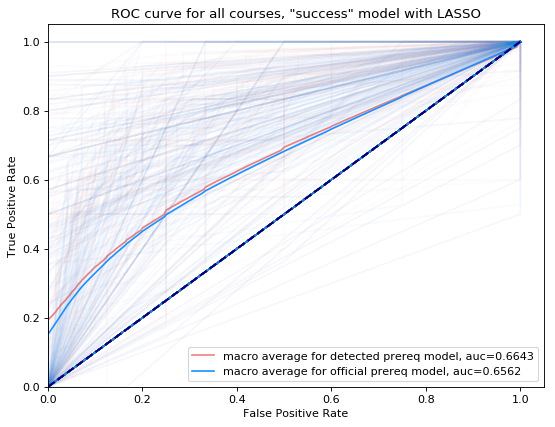

CPU times: user 1h 38min 12s, sys: 6min 57s, total: 1h 45min 9s
Wall time: 1h 45min 29s


In [28]:
%%time

from concurrent.futures import ThreadPoolExecutor

LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
SUCCESS_GRADES = ["A+", "A", "A-", "B+"]
BMINUS_GRADES = ["A+", "A", "A-", "B+", "B", "B-"]
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]
ALL_COURSES = set(raw_data["course_name"]) 

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = True # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l1'
C = 0.1
random_seed = 42
solver = 'liblinear'

PATHNAME = "success_lasso"
PLOT_TITLE = "ROC curve for all courses, \"success\" model with LASSO"

limited_run = True
limit_count = 20
###############################################

results_full = []
results_prereq = []

count = 0
if limited_run:
    limit = limit_count
else:
    limit = len(courselist)

executor = ThreadPoolExecutor()
for course_name in courselist:
    executor.submit(run_predictions_with_prereqs, course_name, results_full, results_prereq, TEST_QUARTERS, 
                    gender_param, gpa_param, x1grades_param, y1grades_param, dev, penalty, C, random_seed, solver)

# #     seems like most of the time is spent executing the threads, not submitting them
#     count += 1
#     print(str(count) + " of " + str(limit))

    if limited_run:
        if count == limit_count:
            break
executor.shutdown()

if limited_run:
    PATHNAME = PATHNAME + "_limited" + str(limit_count)

if dev:
    plot_roc(results_full, results_prereq, PATHNAME, PLOT_TITLE)

results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)
RESULTS_FULL_PATH_CSV = "../results/" + PATHNAME + "_full.csv"
RESULTS_PREREQ_PATH_CSV = "../results/" + PATHNAME + "_prereq.csv"
results_full_df.to_csv(RESULTS_FULL_PATH_CSV)
results_prereq_df.to_csv(RESULTS_PREREQ_PATH_CSV)

# # feather currently doesn't work for some reason
# RESULTS_FULL_PATH = "../results/" + PATHNAME + "_full.fthr"
# RESULTS_PREREQ_PATH = "../results/" + PATHNAME + "_prereq.fthr"
# results_full_df.to_feather(RESULTS_FULL_PATH)
# results_prereq_df.to_feather(RESULTS_PREREQ_PATH)

# models run:

## 2020-05-22 "absolute_baseline", unregularized pass-pass

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = PASS_GRADES
y1grades_param = PASS_GRADES
dev = True
penalty = 'none'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "absolute_baseline"
PLOT_TITLE = "ROC curve for all courses, baseline model"

limited_run = False
limit_count = 20
###############################################

## 2020-05-22 "success_initial", default regularization (L2, C=1.0) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_initial"
PLOT_TITLE = "ROC curve for all courses, initial \"success\" model"

limited_run = False
limit_count = 20
###############################################

## 2020-05-22 "success_lasso", L1 regularization C=0.1 with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l1'
C = 0.1
random_seed = 42
solver = 'liblinear'

PATHNAME = "success_lasso"
PLOT_TITLE = "ROC curve for all courses, \"success\" model with LASSO"

limited_run = False
limit_count = 20
###############################################

## LASSO logistic regression to reduce nonzero coefficients

In [ ]:
# TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

# def one_course_lasso(course_name, test_quarters = TEST_QUARTERS, gender = False, gpa= False, prereqSuccess = False):
#     X_train, X_test, y_train, y_test, fail_flag = get_and_split_data(course_name, test_quarters, gender, gpa = gpa, prereqSuccess = prereqSuccess)
#     for i in [10, 3, 1, 0.3, 0.1, 0.03, 0.01]:
#         model = LogisticRegression(penalty="l1", solver="saga", C=i, max_iter=1000) 
#         model.fit(X_train, y_train)
#         train_score = model.score(X_train, y_train)
#         test_score = model.score(X_test, y_test) 
#         print("\n***** C = {} *****".format(i))
#         print("training accuracy: {}, ground truth (proportion y = 1): {}".format(train_score, y_train.mean()))
#         print("test accuracy: {}, ground truth (proportion y = 1): {}".format(test_score, y_test.mean()))
        
#         coefs = [(X_train.columns[i], model.coef_[0][i]) for i in range(len(X_train.columns))]
#         coefs_pos = sorted(coefs, key = lambda x: x[1], reverse = True)
#         coefs_neg = sorted(coefs, key = lambda x: x[1], reverse = False)
#         coefs_abs = sorted(coefs, key = lambda x: abs(x[1]), reverse = True)
#         coefs_nonzero = sum([x[1] != 0 for x in coefs])
#         coefs_zero = sum(x[1] == 0 for x in coefs)
#         print("Number of nonzero/zero coefficients: {}/{}".format(coefs_nonzero, coefs_zero))
#         print("Largest absolute coefficients:")
#         pprint(coefs_abs[:3])
#         print("Largest positive coefficients:")
#         pprint(coefs_pos[:3])
#         print("Largest negative coefficients:")
#         pprint(coefs_neg[:3])